In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import os
import numpy as np
import time
import random
import pandas as pd
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt

import soundfile
import torchaudio

from ast_models import ASTModel
# from speechbrain.pretrained import EncoderClassifier
# classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", run_opts={"device":"cuda"})

# from speechbrain.pretrained import SpeakerRecognition
# verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", run_opts={"device":"cuda"}, 
#                                                savedir="pretrained_models/spkrec-ecapa-voxceleb")

In [2]:
input_tdim = 500
ast_mdl = ASTModel(label_dim=1,
                    fshape=128, tshape=2, fstride=128, tstride=1,
                    input_fdim=128, input_tdim=input_tdim, model_size='base',
                    pretrain_stage=False, load_pretrained_mdl_path='./ckp/SSAST-Base-Frame-400.pth')
'''
ft10是AISHELL1+AISHELL3训练的
ast_mdl_11是仅用AISHELL3训练的
'''
state_dict = torch.load('./ckp/ft10.pth')
ast_mdl.load_state_dict(state_dict, strict=False)
ast_mdl = ast_mdl.cuda()

now load a SSL pretrained models from ./ckp/SSAST-Base-Frame-400.pth
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=512
pretraining number of patches=512
fine-tuning patch split stride: frequncey=128, time=1
fine-tuning number of patches=499


D:\anaconda\envs\pytorch19\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [3]:
from scipy.io.wavfile import read
from tacotron2.layers import TacotronSTFT

target_length = 500

def load_wav_to_torch(full_path):
    """
    Loads wavdata into torch array
    """
    sampling_rate, data = read(full_path)
    return torch.from_numpy(data).float(), sampling_rate


stft = TacotronSTFT(filter_length=1024,
                    hop_length=256,
                    win_length=1024,
                    sampling_rate=22050,
                    mel_fmin=0, mel_fmax=8000)

def get_mel_a(audio):
    audio_norm = audio / 32768.0
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(melspec, 0).T
    '''
     mel = (D, T)
    '''
        
    #cut and pad
    n_frames = melspec.shape[0]
    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        melspec = m(melspec)
    elif p < 0:
        melspec = melspec[0:target_length, :]       
            
    return melspec

D:\MyPython_file\pytorch_file\DDPM\A_PJ3\Spk_verification\tacotron2\stft.py:67: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
D:\MyPython_file\pytorch_file\DDPM\A_PJ3\Spk_verification\tacotron2\layers.py:50: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=128, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [5]:
def data_prepar_spk(data_file):
    file_list, file_org_list = [], []
    with open(data_file, 'r', encoding='utf-8') as infile:
        # file_list, label_list = [], []
        for line in infile:
            data_line = line.strip("\n").split()  # 去除首尾换行符，并按空格划分    
            file_list.append(data_line[0])
            file_org_list.append(data_line[1])
   
    return file_list, file_org_list

In [6]:
def data_prepar_joint_spk(data_file):
    file_list, file_org_list,label_list = [], [], []
    with open(data_file, 'r', encoding='utf-8') as infile:
        # file_list, label_list = [], []
        for line in infile:
            data_line = line.strip("\n").split()  # 去除首尾换行符，并按空格划分    
            file_list.append(data_line[0])
            file_org_list.append(data_line[1])
            label_list.append(float(data_line[2]))
   
    return file_list, file_org_list, label_list

In [7]:
def est(test_files, org_files, threshold=0.55): 
    similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    filenums = len(test_files)
    pre_score = 0
    since = time.time()
    i = 1
    for test_v, org_v in zip(test_files, org_files):          
        test_voice, _ = librosa.load(test_v) 
        org_voice, _ = librosa.load(org_v) 
        test_voice = torch.from_numpy(test_voice).float()
        org_voice = torch.from_numpy(org_voice).float()
        # try:
        rev_emb = classifier.encode_batch(test_voice).clone().detach()
        org_emb = classifier.encode_batch(org_voice).clone().detach()
        sim = similarity(rev_emb, org_emb)
        if sim>threshold:
            pre_score+=1 
            
        # except:
        #    print(test_v) 
        
        if i % 128 == 0:
            time_elapsed = time.time() - since 
            print (int(i/128),'/',int(len(test_files)/128), pre_score/i) 
            print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        i += 1
    
    acc = pre_score/filenums
    return 1-acc

In [99]:
test_files, org_files = data_prepar_spk('ASV_A1_unseen.txt')

In [100]:
est(test_files, org_files)

1 / 168 1.0
Testing complete in 0m 6s
2 / 168 0.99609375
Testing complete in 0m 11s
3 / 168 0.9921875
Testing complete in 0m 17s
4 / 168 0.994140625
Testing complete in 0m 23s
5 / 168 0.99375
Testing complete in 0m 28s
6 / 168 0.9921875
Testing complete in 0m 34s
7 / 168 0.9921875
Testing complete in 0m 39s
8 / 168 0.9873046875
Testing complete in 0m 45s
9 / 168 0.9878472222222222
Testing complete in 0m 50s
10 / 168 0.9890625
Testing complete in 0m 56s
11 / 168 0.9865056818181818
Testing complete in 1m 1s
12 / 168 0.9856770833333334
Testing complete in 1m 7s
13 / 168 0.9813701923076923
Testing complete in 1m 13s
14 / 168 0.9787946428571429
Testing complete in 1m 18s
15 / 168 0.9791666666666666
Testing complete in 1m 24s
16 / 168 0.97900390625
Testing complete in 1m 29s
17 / 168 0.9793198529411765
Testing complete in 1m 35s
18 / 168 0.9791666666666666
Testing complete in 1m 40s
19 / 168 0.9786184210526315
Testing complete in 1m 46s
20 / 168 0.978515625
Testing complete in 1m 51s
21 / 16

0.03227156475238313

In [ ]:
0.0026040455707975196

In [57]:
0.012973727040223149

0.012973727040223149

In [101]:
test_files, org_files, test_labels = data_prepar_joint_spk('pitch_scaling_validation1_praat.txt')

In [105]:
def est_scaled(test_files, org_files, test_labels, threshold=0.4): 
    similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    pre_nums=0 
    pre_score=0
    pre_nums1=0
    pre_score1=0
    pre_nums2=0
    pre_score2=0 
    pre_nums3=0
    pre_score3=0
    pre_nums4=0
    pre_score4=0
    pre_nums5=0
    pre_score5=0
    pre_nums6=0
    pre_score6=0
    pre_nums7=0
    pre_score7=0
    pre_nums8=0
    pre_score8=0
    pre_nums9=0
    pre_score9=0
    pre_nums10=0
    pre_score10=0

    pre_nums11=0
    pre_score11=0
    pre_nums12=0
    pre_score12=0 
    pre_nums13=0
    pre_score13=0
    pre_nums14=0
    pre_score14=0
    pre_nums15=0
    pre_score15=0
    pre_nums16=0
    pre_score16=0
    pre_nums17=0
    pre_score17=0
    pre_nums18=0
    pre_score18=0
    pre_nums19=0
    pre_score19=0
    pre_nums20=0
    pre_score20=0
    
    pre_nums21=0
    pre_score21=0
    pre_nums22=0
    pre_score22=0 
    pre_nums23=0
    pre_score23=0
    pre_nums24=0
    pre_score24=0
    pre_nums25=0
    pre_score25=0
    pre_nums26=0
    pre_score26=0
    pre_nums27=0
    pre_score27=0
    pre_nums28=0
    pre_score28=0
    pre_nums29=0
    pre_score29=0
    pre_nums30=0
    pre_score30=0
    pre_nums31=0
    pre_score31=0
    pre_nums32=0
    pre_score32=0
    since = time.time()
    i = 1
    for test_v, org_v, label in zip(test_files, org_files, test_labels):
        alpha = float(label)
        if alpha==0.0:
            pre_nums+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score+=1 
     
        elif alpha==0.5:
            pre_nums1+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score1+=1 
                
        if alpha==-0.5:
            pre_nums2+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score2+=1 
                
        elif alpha==1:
            pre_nums3+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score3+=1
        
        elif alpha==-1:
            pre_nums4+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score4+=1
                
        elif alpha==1.5:
            pre_nums5+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score5+=1
        
        elif alpha==-1.5:
            pre_nums6+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score6+=1
        
        elif alpha==2:
            pre_nums7+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score7+=1         
        
        elif alpha==-2:
            pre_nums8+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score8+=1
        
        elif alpha==2.5:
            pre_nums9+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score9+=1 
        
        elif alpha==-2.5:
            pre_nums10+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score10+=1 
                
        elif alpha==3:
            pre_nums11+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score11+=1          
                
        elif alpha==-3:
            pre_nums12+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score12+=1
                
        elif alpha==3.5:
            pre_nums13+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score13+=1
                
        elif alpha==-3.5:
            pre_nums14+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score14+=1  
                
        elif alpha==4:
            pre_nums15+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score15+=1

        elif alpha==-4:
            pre_nums16+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score16+=1
                
        elif alpha==4.5:
            pre_nums17+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score17+=1

        elif alpha==-4.5:
            pre_nums18+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score18+=1
                
        elif alpha==5:
            pre_nums19+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score19+=1

        elif alpha==-5:
            pre_nums20+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score20+=1
                
        elif alpha==5.5:
            pre_nums21+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score21+=1

        elif alpha==-5.5:
            pre_nums22+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score22+=1
                
        elif alpha==6:
            pre_nums23+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score23+=1
 
        elif alpha==-6:
            pre_nums24+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score24+=1
                
        elif alpha==6.5:
            pre_nums25+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score25+=1
 
        elif alpha==-6.5:
            pre_nums26+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score26+=1
                
        elif alpha==7:
            pre_nums27+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score27+=1

        elif alpha==-7:
            pre_nums28+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score28+=1
                
        elif alpha==7.5:
            pre_nums29+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score29+=1    
                
        elif alpha==-7.5:
            pre_nums30+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score30+=1   
                
        elif alpha==8:
            pre_nums31+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_nums31+=1
                
        elif alpha==-8:
            pre_nums32+=1
            test_voice, _ = librosa.load(test_v) 
            org_voice, _ = librosa.load(org_v) 
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()
            # try:
            rev_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(rev_emb, org_emb)
            if sim>threshold:
                pre_score32+=1 
        
        else:
            print(test_v, alpha)
            
            
        # except:
        #    print(test_v) 
        
        if i % 128 == 0:
            time_elapsed = time.time() - since 
            print (int(i/128),'/',int(len(test_files)/128))
                   # pre_score/pre_nums, pre_score1/pre_nums1, pre_score2/pre_nums2, pre_score3/pre_nums3, 
                   # pre_score4/pre_nums4, pre_score5/pre_nums5, pre_score6/pre_nums6, pre_score7/pre_nums7, pre_score8/pre_nums8, pre_score9/pre_nums9, 
                   # pre_score10/pre_nums10, pre_score11/pre_nums11, pre_score12/pre_nums12, pre_score13/pre_nums13, pre_score14/pre_nums14, 
                   # pre_score15/pre_nums15, pre_score16/pre_nums16, pre_score17/pre_nums17, pre_score18/pre_nums18, pre_score19/pre_nums19, 
                   # pre_score20/pre_nums20, pre_score21/pre_nums21, pre_score22/pre_nums22, pre_score23/pre_nums23, pre_score24/pre_nums24, 
                   # pre_score25/pre_nums25, pre_score26/pre_nums26, pre_score27/pre_nums27, pre_score28/pre_nums28, pre_score29/pre_nums29, 
                   # pre_score30/pre_nums30, pre_score31/pre_nums31, pre_score32/pre_nums32) 
            
            print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        i += 1
    
    acc = pre_score/pre_nums
    acc1 = pre_score1/pre_nums1
    acc2 = pre_score2/pre_nums2
    acc3 = pre_score3/pre_nums3
    acc4 = pre_score4/pre_nums4
    acc5 = pre_score5/pre_nums5
    acc6 = pre_score6/pre_nums6
    acc7 = pre_score7/pre_nums7
    acc8 = pre_score8/pre_nums8
    acc9 = pre_score9/pre_nums9
    # acc10 = pre_score10/pre_nums10
    acc11 = pre_score11/pre_nums11
    acc12 = pre_score12/pre_nums12
    acc13 = pre_score13/pre_nums13
    acc14 = pre_score14/pre_nums14
    acc15 = pre_score15/pre_nums15
    acc16 = pre_score16/pre_nums16
    # acc17 = pre_score17/pre_nums17
    acc18 = pre_score18/pre_nums18
    acc19 = pre_score19/pre_nums19
    acc20 = pre_score20/pre_nums20
    acc21 = pre_score21/pre_nums21
    acc22 = pre_score22/pre_nums22
    acc23 = pre_score23/pre_nums23
    acc24 = pre_score24/pre_nums24
    acc25 = pre_score25/pre_nums25
    acc26 = pre_score26/pre_nums26
    acc27 = pre_score27/pre_nums27
    acc28 = pre_score28/pre_nums28
    acc29 = pre_score29/pre_nums29
    acc30 = pre_score30/pre_nums30
    acc31 = pre_score31/pre_nums31
    acc32 = pre_score32/pre_nums32

    return 1-acc, 1-acc2, 1-acc3, 1-acc4, 1-acc5, 1-acc6, 1-acc7, 1-acc8, 1-acc9, 1-acc11, 1-acc12, 1-acc13, 1-acc14, 1-acc15, 1-acc16, 1-acc18, 1-acc19, 1-acc20, 1-acc21, 1-acc22, 1-acc23, 1-acc24, 1-acc25, 1-acc26, 1-acc27, 1-acc28, 1-acc29, 1-acc30, 1-acc31, 1-acc32, 

In [106]:
est_scaled(test_files, org_files, test_labels)

1 / 157
Testing complete in 0m 6s
2 / 157
Testing complete in 0m 12s
3 / 157
Testing complete in 0m 17s
4 / 157
Testing complete in 0m 23s
5 / 157
Testing complete in 0m 29s
6 / 157
Testing complete in 0m 34s
7 / 157
Testing complete in 0m 40s
8 / 157
Testing complete in 0m 46s
9 / 157
Testing complete in 0m 52s
10 / 157
Testing complete in 0m 57s
11 / 157
Testing complete in 1m 3s
12 / 157
Testing complete in 1m 9s
13 / 157
Testing complete in 1m 14s
14 / 157
Testing complete in 1m 20s
15 / 157
Testing complete in 1m 26s
16 / 157
Testing complete in 1m 31s
17 / 157
Testing complete in 1m 37s
18 / 157
Testing complete in 1m 43s
19 / 157
Testing complete in 1m 49s
20 / 157
Testing complete in 1m 54s
21 / 157
Testing complete in 1m 60s
22 / 157
Testing complete in 2m 6s
23 / 157
Testing complete in 2m 11s
24 / 157
Testing complete in 2m 17s
25 / 157
Testing complete in 2m 23s
26 / 157
Testing complete in 2m 28s
27 / 157
Testing complete in 2m 34s
28 / 157
Testing complete in 2m 40s
29 / 

(0.0,
 0.004608294930875556,
 0.0,
 0.0,
 0.0,
 0.001536098310291889,
 0.001536098310291889,
 0.0,
 0.001536098310291889,
 0.001536098310291889,
 0.0,
 0.0,
 0.001536098310291889,
 0.003072196620583667,
 0.006144393241167445,
 0.004608294930875556,
 0.006144393241167445,
 0.001536098310291889,
 0.003072196620583667,
 0.003072196620583667,
 0.003072196620583667,
 0.004608294930875556,
 0.010752688172043001,
 0.004608294930875556,
 0.016897081413210446,
 0.01228878648233489,
 0.02457757296466978,
 0.010752688172043001,
 1.0,
 0.01382488479262678)

In [14]:
def ASV_ERR(test_files, org_files, threshold=0.4): 
    similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    filenums = len(test_files)
    pre_score = 0
    since = time.time()
    i = 1
    for test_v, org_v in zip(test_files, org_files):          
        test_voice, _ = librosa.load(test_v) 
        mel = get_mel_a(test_voice)
        pred_alpha = ast_mdl(mel)
        restore_voice = librosa.effects.pitch_shift(test_voice, sr=22050, n_steps=-pred_alpha, bins_per_octave=12)
        org_voice, _ = librosa.load(org_v)
        restore_voice = torch.from_numpy(restore_voice).float()
        org_voice = torch.from_numpy(org_voice).float()
        # try:
        res_emb = classifier.encode_batch(restore_voice).clone().detach()
        org_emb = classifier.encode_batch(org_voice).clone().detach()
        sim = similarity(res_emb, org_emb)
        
        if sim>threshold:
            pre_score+=1 
    
        # except:
        #    print(test_v) 
        
        if i % 128 == 0:
            time_elapsed = time.time() - since 
            print (int(i/128),'/',int(len(test_files)/128), pre_score/i) 
            print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        i += 1
    
    acc = pre_score/filenums
    
    return 1-acc

In [4]:
def ASV_ERR(test_files, org_files, threshold=0.35): 
    similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    pre_score = 0
    
    test_voice, _ = load_wav_to_torch(test_files)
    mel = get_mel_a(test_voice).unsqueeze(0).cuda()
    pred_alpha = ast_mdl(mel, task='ft_cls').detach()
    restore_voice = librosa.effects.pitch_shift(test_voice.cpu().numpy(), sr=22050, n_steps=-pred_alpha, bins_per_octave=12)
    org_voice, _ = librosa.load(org_files)
    restore_voice = torch.from_numpy(restore_voice).float()
    org_voice = torch.from_numpy(org_voice).float()
    # try:
    res_emb = classifier.encode_batch(restore_voice).clone().detach()
    org_emb = classifier.encode_batch(org_voice).clone().detach()
    sim = similarity(res_emb, org_emb)
        
    if sim>threshold:
        pre_score=1 
 
    return pre_score

In [5]:
def revers_f(org_voice, dis_voice, sr, a):
    '''
    step 1: revers disguished voice
    step 2: calculate similarity
    '''
    rev_vc = librosa.effects.pitch_shift(dis_voice, sr=sr, n_steps=-a, bins_per_octave=12)
    rev_vc = torch.from_numpy(rev_vc).float()
    rev_emb = classifier.encode_batch(rev_vc).clone().detach()
    return rev_emb, a


def TIFS(org_voice, dis_voice, sr):
    org_sim = 0 
    org_alpha = 0
    similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    org_voice = torch.from_numpy(org_voice).float()
    org_emb = classifier.encode_batch(org_voice).clone().detach()
    
    for a in range(-8, 8, 1):
        rev_emb, alpha = revers_f(org_voice, dis_voice, sr, a)
        sim = similarity(org_emb, rev_emb)
        if sim >= org_sim:
            org_sim = sim
            org_alpha = alpha
            
    return org_alpha

In [6]:
def ASV_ERR_TIFS(test_files, org_files, threshold=0.55): 
    similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    pre_score = 0
    
    test_voice, sr = librosa.load(test_files)
    org_voice, _ = librosa.load(org_files)
    pred_alpha = TIFS(org_voice, test_voice, sr)
    restore_voice = librosa.effects.pitch_shift(test_voice, sr=22050, n_steps=-pred_alpha, bins_per_octave=12)
    restore_voice = torch.from_numpy(restore_voice).float()
    org_voice = torch.from_numpy(org_voice).float()
    # try:
    res_emb = classifier.encode_batch(restore_voice).clone().detach()
    org_emb = classifier.encode_batch(org_voice).clone().detach()
    sim = similarity(res_emb, org_emb)
        
    if sim>threshold:
        pre_score=1 
 
    return pre_score

### Recover

In [18]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_matlab/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    for file in filelist:
        scaled_wav = os.path.join(filepath, a, file)
        spk_id = str(file.split('.')[0][6:11])
        org_filelist = os.listdir(os.path.join(org_filepath, spk_id))
        random.shuffle(org_filelist)
        org_wav = os.path.join(org_filepath, spk_id, org_filelist[0])
        try:  
            score = ASV_ERR(scaled_wav, org_wav)
            total_score += score
        except:
            print(file)
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

-0.5 : err is: 0.009216589861751112
total test file nums are: 651
Testing complete in 1m 53s
-1.0 : err is: 0.007680491551459334
total test file nums are: 651
Testing complete in 1m 56s
-1.5 : err is: 0.004608294930875556
total test file nums are: 651
Testing complete in 2m 1s
-2.0 : err is: 0.009216589861751112
total test file nums are: 651
Testing complete in 1m 60s
-2.5 : err is: 0.01228878648233489
total test file nums are: 651
Testing complete in 2m 1s
-3.0 : err is: 0.007680491551459334
total test file nums are: 651
Testing complete in 2m 2s
-3.5 : err is: 0.004608294930875556
total test file nums are: 651
Testing complete in 2m 4s
-4.0 : err is: 0.006144393241167445
total test file nums are: 651
Testing complete in 2m 6s
-4.5 : err is: 0.009216589861751112
total test file nums are: 651
Testing complete in 2m 8s
-5.0 : err is: 0.001536098310291889
total test file nums are: 651
Testing complete in 2m 11s
-5.5 : err is: 0.001536098310291889
total test file nums are: 651
Testing com

In [7]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_Audacity/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    for file in filelist:
        scaled_wav = os.path.join(filepath, a, file)
        spk_id = str(file.split('.')[0][6:11])
        org_filelist = os.listdir(os.path.join(org_filepath, spk_id))
        random.shuffle(org_filelist)
        org_wav = os.path.join(org_filepath, spk_id, org_filelist[0])
        try:  
            score = ASV_ERR(scaled_wav, org_wav)
            total_score += score
        except:
            print(file)
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

C:\Users\LYC\AppData\Local\Temp/ipykernel_4756/2222669940.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = read(full_path)
C:\Users\LYC\AppData\Local\Temp/ipykernel_4756/2222669940.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = read(full_path)


-0.5 : err is: 0.01382488479262678
total test file nums are: 651
Testing complete in 2m 1s
-1.0 : err is: 0.030721966205837226
total test file nums are: 651
Testing complete in 2m 3s
-1.5 : err is: 0.05069124423963134
total test file nums are: 651
Testing complete in 2m 5s
-2.0 : err is: 0.07987711213517668
total test file nums are: 651
Testing complete in 2m 5s
-2.5 : err is: 0.06298003072196623
total test file nums are: 651
Testing complete in 2m 5s
-3.0 : err is: 0.09216589861751157
total test file nums are: 651
Testing complete in 2m 11s
-3.5 : err is: 0.09062980030721968
total test file nums are: 651
Testing complete in 2m 19s
-4.0 : err is: 0.08141321044546856
total test file nums are: 651
Testing complete in 2m 11s
-4.5 : err is: 0.0768049155145929
total test file nums are: 651
Testing complete in 2m 14s
-5.0 : err is: 0.03993855606758834
total test file nums are: 651
Testing complete in 2m 16s
-5.5 : err is: 0.03840245775729645
total test file nums are: 651
Testing complete in 

In [27]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_soundtouch/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    for file in filelist:
        scaled_wav = os.path.join(filepath, a, file)
        spk_id = str(file.split('.')[0][6:11])
        org_filelist = os.listdir(os.path.join(org_filepath, spk_id))
        random.shuffle(org_filelist)
        org_wav = os.path.join(org_filepath, spk_id, org_filelist[0])
        try:  
            score = ASV_ERR(scaled_wav, org_wav)
            total_score += score
        except:
            print(file)
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

-0.5 : err is: 0.006144393241167445
total test file nums are: 651
Testing complete in 2m 3s
-1.0 : err is: 0.01382488479262678
total test file nums are: 651
Testing complete in 2m 2s
-1.5 : err is: 0.06144393241167434
total test file nums are: 651
Testing complete in 1m 60s
-2.0 : err is: 0.10138248847926268
total test file nums are: 651
Testing complete in 2m 2s
-2.5 : err is: 0.06758832565284179
total test file nums are: 651
Testing complete in 2m 7s
-3.0 : err is: 0.021505376344086002
total test file nums are: 651
Testing complete in 2m 11s
-3.5 : err is: 0.009216589861751112
total test file nums are: 651
Testing complete in 2m 14s
-4.0 : err is: 0.006144393241167445
total test file nums are: 651
Testing complete in 2m 13s
-4.5 : err is: 0.007680491551459334
total test file nums are: 651
Testing complete in 2m 16s
-5.0 : err is: 0.009216589861751112
total test file nums are: 651
Testing complete in 2m 17s
-5.5 : err is: 0.001536098310291889
total test file nums are: 651
Testing comp

In [29]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_Audition/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    for file in filelist:
        scaled_wav = os.path.join(filepath, a, file)
        spk_id = str(file.split('.')[0][6:11])
        org_filelist = os.listdir(os.path.join(org_filepath, spk_id))
        random.shuffle(org_filelist)
        org_wav = os.path.join(org_filepath, spk_id, org_filelist[0])
        try:  
            score = ASV_ERR(scaled_wav, org_wav)
            total_score += score
        except:
            print(file)
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

BAC009S0745W0447.pkf
BAC009S0770W0210.pkf
BAC009S0915W0223.pkf
-0.5 : err is: 0.015290519877675823
total test file nums are: 654
Testing complete in 1m 57s
BAC009S0768W0452.pkf
-1.0 : err is: 0.010736196319018454
total test file nums are: 652
Testing complete in 2m 1s
BAC009S0915W0199.pkf
-1.5 : err is: 0.013803680981595123
total test file nums are: 652
Testing complete in 2m 4s
-2.0 : err is: 0.007680491551459334
total test file nums are: 651
Testing complete in 2m 4s
-2.5 : err is: 0.004608294930875556
total test file nums are: 651
Testing complete in 2m 5s
-3.0 : err is: 0.0
total test file nums are: 651
Testing complete in 2m 7s
-3.5 : err is: 0.0
total test file nums are: 651
Testing complete in 2m 10s
-4.0 : err is: 0.0
total test file nums are: 651
Testing complete in 2m 11s
-4.5 : err is: 0.004608294930875556
total test file nums are: 651
Testing complete in 2m 13s
BAC009S0913W0140.pkf
-5.0 : err is: 0.0030674846625766694
total test file nums are: 652
Testing complete in 2m 16s

In [38]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_iZotope/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    for file in filelist:
        scaled_wav = os.path.join(filepath, a, file)
        spk_id = str(file.split('.')[0][6:11])
        org_filelist = os.listdir(os.path.join(org_filepath, spk_id))
        random.shuffle(org_filelist)
        org_wav = os.path.join(org_filepath, spk_id, org_filelist[0])
        try:  
            score = ASV_ERR(scaled_wav, org_wav)
            total_score += score
        except:
            print(file)
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

BAC009S0745W0447.pkf
BAC009S0770W0210.pkf
BAC009S0915W0223.pkf
-0.5 : err is: 0.013761467889908285
total test file nums are: 654
Testing complete in 2m 0s
BAC009S0768W0452.pkf
-1.0 : err is: 0.010736196319018454
total test file nums are: 652
Testing complete in 2m 1s
BAC009S0915W0199.pkf
-1.5 : err is: 0.006134969325153339
total test file nums are: 652
Testing complete in 2m 3s
-2.0 : err is: 0.004608294930875556
total test file nums are: 651
Testing complete in 2m 5s
-2.5 : err is: 0.009216589861751112
total test file nums are: 651
Testing complete in 2m 6s
-3.0 : err is: 0.001536098310291889
total test file nums are: 651
Testing complete in 2m 10s
-3.5 : err is: 0.001536098310291889
total test file nums are: 651
Testing complete in 2m 14s
-4.0 : err is: 0.003072196620583667
total test file nums are: 651
Testing complete in 2m 17s
-4.5 : err is: 0.001536098310291889
total test file nums are: 651
Testing complete in 2m 22s
BAC009S0913W0140.pkf
-5.0 : err is: 0.006134969325153339
total 

In [23]:
F.sigmoid(torch.tensor(0.36406))

tensor(0.5900)

In [37]:
0.116743471582181+0.0129737270402231

0.1297171986224041

### Non Recover

In [7]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_iZotope/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    for file in filelist:
        try:
            score = 0
            scaled_wav = os.path.join(filepath, a, file)
            spk_id = str(file.split('.')[0][6:11])
            
            org_filelist = os.listdir(os.path.join(org_filepath, spk_id))
            random.shuffle(org_filelist)
            org_wav = os.path.join(org_filepath, spk_id, org_filelist[0])     
    
            test_voice, _ = librosa.load(scaled_wav)
            org_voice, _ = librosa.load(org_wav)
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()   
            test_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(test_emb, org_emb)     
            if sim > 0.35:
                score = 1 

            total_score += score
        except:
            print(file)
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

D:\anaconda\envs\pytorch19\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


BAC009S0745W0447.pkf
BAC009S0770W0210.pkf
BAC009S0915W0223.pkf
-0.5 : err is: 0.007645259938837912
total test file nums are: 654
Testing complete in 0m 34s
BAC009S0768W0452.pkf
-1.0 : err is: 0.009202453987730008
total test file nums are: 652
Testing complete in 0m 30s
BAC009S0915W0199.pkf
-1.5 : err is: 0.015337423312883458
total test file nums are: 652
Testing complete in 0m 29s
-2.0 : err is: 0.053763440860215006
total test file nums are: 651
Testing complete in 0m 30s
-2.5 : err is: 0.12288786482334868
total test file nums are: 651
Testing complete in 0m 30s
-3.0 : err is: 0.21351766513056836
total test file nums are: 651
Testing complete in 0m 30s
-3.5 : err is: 0.34562211981566815
total test file nums are: 651
Testing complete in 0m 30s
-4.0 : err is: 0.44393241167434716
total test file nums are: 651
Testing complete in 0m 30s
-4.5 : err is: 0.5268817204301075
total test file nums are: 651
Testing complete in 0m 30s
BAC009S0913W0140.pkf
-5.0 : err is: 0.6411042944785277
total tes

In [16]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_soundtouch/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    for file in filelist:
        score = 0
        scaled_wav = os.path.join(filepath, a, file)
        spk_id = str(file.split('.')[0][6:11])
            
        org_filelist = os.listdir(os.path.join(org_filepath, spk_id))
        random.shuffle(org_filelist)
        org_wav = os.path.join(org_filepath, spk_id, org_filelist[0])     
    
        test_voice, _ = librosa.load(scaled_wav)
        org_voice, _ = librosa.load(org_wav)
        test_voice = torch.from_numpy(test_voice).float()
        org_voice = torch.from_numpy(org_voice).float()   
        test_emb = classifier.encode_batch(test_voice).clone().detach()
        org_emb = classifier.encode_batch(org_voice).clone().detach()
        sim = similarity(test_emb, org_emb)     
        if sim > 0.35:
            score = 1 
            
        total_score += score
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

-0.5 : err is: 0.004608294930875556
total test file nums are: 651
Testing complete in 0m 30s
-1.0 : err is: 0.009216589861751112
total test file nums are: 651
Testing complete in 0m 30s
-1.5 : err is: 0.027649769585253448
total test file nums are: 651
Testing complete in 0m 30s
-2.0 : err is: 0.11059907834101379
total test file nums are: 651
Testing complete in 0m 30s
-2.5 : err is: 0.22887864823348691
total test file nums are: 651
Testing complete in 0m 31s
-3.0 : err is: 0.3486943164362519
total test file nums are: 651
Testing complete in 0m 33s
-3.5 : err is: 0.49923195084485406
total test file nums are: 651
Testing complete in 0m 32s
-4.0 : err is: 0.4807987711213517
total test file nums are: 651
Testing complete in 0m 31s
-4.5 : err is: 0.5545314900153611
total test file nums are: 651
Testing complete in 0m 30s
-5.0 : err is: 0.6682027649769585
total test file nums are: 651
Testing complete in 0m 29s
-5.5 : err is: 0.7557603686635945
total test file nums are: 651
Testing complete 

In [19]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_matlab/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    for file in filelist:
        score = 0
        scaled_wav = os.path.join(filepath, a, file)
        spk_id = str(file.split('.')[0][6:11])
            
        org_filelist = os.listdir(os.path.join(org_filepath, spk_id))
        random.shuffle(org_filelist)
        org_wav = os.path.join(org_filepath, spk_id, org_filelist[0])     
    
        test_voice, _ = librosa.load(scaled_wav)
        org_voice, _ = librosa.load(org_wav)
        test_voice = torch.from_numpy(test_voice).float()
        org_voice = torch.from_numpy(org_voice).float()   
        test_emb = classifier.encode_batch(test_voice).clone().detach()
        org_emb = classifier.encode_batch(org_voice).clone().detach()
        sim = similarity(test_emb, org_emb)     
        if sim > 0.35:
            score = 1 
            
        total_score += score
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

-0.5 : err is: 0.007680491551459334
total test file nums are: 651
Testing complete in 0m 29s
-1.0 : err is: 0.016897081413210446
total test file nums are: 651
Testing complete in 0m 29s
-1.5 : err is: 0.06451612903225812
total test file nums are: 651
Testing complete in 0m 29s
-2.0 : err is: 0.15053763440860213
total test file nums are: 651
Testing complete in 0m 29s
-2.5 : err is: 0.2519201228878648
total test file nums are: 651
Testing complete in 0m 29s
-3.0 : err is: 0.3978494623655914
total test file nums are: 651
Testing complete in 0m 30s
-3.5 : err is: 0.5576036866359446
total test file nums are: 651
Testing complete in 0m 30s
-4.0 : err is: 0.7127496159754224
total test file nums are: 651
Testing complete in 0m 29s
-4.5 : err is: 0.804915514592934
total test file nums are: 651
Testing complete in 0m 29s
-5.0 : err is: 0.8617511520737327
total test file nums are: 651
Testing complete in 0m 29s
-5.5 : err is: 0.9278033794162827
total test file nums are: 651
Testing complete in 0

In [20]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_Audacity/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    for file in filelist:
        score = 0
        scaled_wav = os.path.join(filepath, a, file)
        spk_id = str(file.split('.')[0][6:11])
        '''
        precision + recall
        '''
        org_filelist = os.listdir(os.path.join(org_filepath, spk_id))
        random.shuffle(org_filelist)
        org_wav = os.path.join(org_filepath, spk_id, org_filelist[0])     
    
        test_voice, _ = librosa.load(scaled_wav)
        org_voice, _ = librosa.load(org_wav)
        test_voice = torch.from_numpy(test_voice).float()
        org_voice = torch.from_numpy(org_voice).float()   
        test_emb = classifier.encode_batch(test_voice).clone().detach()
        org_emb = classifier.encode_batch(org_voice).clone().detach()
        sim = similarity(test_emb, org_emb)     
        if sim > 0.35:
            score = 1 
            
        total_score += score
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

-0.5 : err is: 0.006144393241167445
total test file nums are: 651
Testing complete in 0m 34s
-1.0 : err is: 0.01382488479262678
total test file nums are: 651
Testing complete in 0m 37s
-1.5 : err is: 0.027649769585253448
total test file nums are: 651
Testing complete in 0m 34s
-2.0 : err is: 0.09984639016897079
total test file nums are: 651
Testing complete in 0m 34s
-2.5 : err is: 0.1981566820276498
total test file nums are: 651
Testing complete in 0m 33s
-3.0 : err is: 0.31182795698924726
total test file nums are: 651
Testing complete in 0m 33s
-3.5 : err is: 0.44546850998463905
total test file nums are: 651
Testing complete in 0m 33s
-4.0 : err is: 0.5376344086021505
total test file nums are: 651
Testing complete in 0m 34s
-4.5 : err is: 0.6221198156682028
total test file nums are: 651
Testing complete in 0m 34s
-5.0 : err is: 0.7204301075268817
total test file nums are: 651
Testing complete in 0m 33s
-5.5 : err is: 0.7680491551459293
total test file nums are: 651
Testing complete i

In [22]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_Audition/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    for file in filelist:
        try:
            score = 0
            scaled_wav = os.path.join(filepath, a, file)
            spk_id = str(file.split('.')[0][6:11])
            
            org_filelist = os.listdir(os.path.join(org_filepath, spk_id))
            random.shuffle(org_filelist)
            org_wav = os.path.join(org_filepath, spk_id, org_filelist[0])     
    
            test_voice, _ = librosa.load(scaled_wav)
            org_voice, _ = librosa.load(org_wav)
            test_voice = torch.from_numpy(test_voice).float()
            org_voice = torch.from_numpy(org_voice).float()   
            test_emb = classifier.encode_batch(test_voice).clone().detach()
            org_emb = classifier.encode_batch(org_voice).clone().detach()
            sim = similarity(test_emb, org_emb)     
            if sim > 0.35:
                score = 1 

            total_score += score
        except:
            print(file)
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

BAC009S0745W0447.pkf
BAC009S0770W0210.pkf
BAC009S0915W0223.pkf
-0.5 : err is: 0.006116207951070374
total test file nums are: 654
Testing complete in 0m 32s
BAC009S0768W0452.pkf
-1.0 : err is: 0.009202453987730008
total test file nums are: 652
Testing complete in 0m 35s
BAC009S0915W0199.pkf
-1.5 : err is: 0.016871165644171793
total test file nums are: 652
Testing complete in 0m 35s
-2.0 : err is: 0.06144393241167434
total test file nums are: 651
Testing complete in 0m 35s
-2.5 : err is: 0.11674347158218124
total test file nums are: 651
Testing complete in 0m 34s
-3.0 : err is: 0.21658986175115202
total test file nums are: 651
Testing complete in 0m 35s
-3.5 : err is: 0.35791090629800304
total test file nums are: 651
Testing complete in 0m 35s
-4.0 : err is: 0.4516129032258065
total test file nums are: 651
Testing complete in 0m 35s
-4.5 : err is: 0.5314900153609832
total test file nums are: 651
Testing complete in 0m 36s
BAC009S0913W0140.pkf
-5.0 : err is: 0.6825153374233128
total test 

In [15]:
0.0612557427258805+0.0129737270402231

0.0742294697661036

In [30]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    spkid_list = os.listdir(org_filepath)
    for file in filelist:
        scaled_wav = os.path.join(filepath, a, file)
        test_spk_id = str(file.split('.')[0][6:11])
        random.shuffle(spkid_list)
        org_spk_id = spkid_list[0]      
        if test_spk_id == org_spk_id:
            label = 1
        else:
            label = 0             
        org_filelist = os.listdir(os.path.join(org_filepath, org_spk_id))
        random.shuffle(org_filelist)
        org_wav = os.path.join(org_filepath, org_spk_id, org_filelist[0])     
        pred_label = ASV_ERR(scaled_wav, org_wav)       
        if label==pred_label:
            score=1
        else:
            score=0                 
        total_score += score
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

S0724 : err is: 0.5593220338983051
total test file nums are: 354
Testing complete in 1m 6s


KeyboardInterrupt: 

### ASV_ERR TIFS

In [68]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_soundtouch/'
org_filepath =  'E:/datasets/project3/AISHELL-1/unseen/'
alpha_list = os.listdir(filepath)
for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    filenums = len(filelist)
    total_score = 0
    for file in filelist:
        scaled_wav = os.path.join(filepath, a, file)
        spk_id = str(file.split('.')[0][6:11])
        org_wav = os.path.join(org_filepath, spk_id, file)
        
        score = ASV_ERR_TIFS(scaled_wav, org_wav)
        total_score += score
            
    acc = total_score/filenums
    time_elapsed = time.time() - since
    print(a,':', 'err is:', 1-acc)
    print('total test file nums are:', filenums)
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


-0.5 : err is: 0.0
total test file nums are: 651
Testing complete in 21m 34s
-1.0 : err is: 0.0
total test file nums are: 651
Testing complete in 22m 0s
-1.5 : err is: 0.0
total test file nums are: 651
Testing complete in 22m 29s
-2.0 : err is: 0.0
total test file nums are: 651
Testing complete in 22m 26s


KeyboardInterrupt: 

### EST bar估计区间，蜡烛图

In [ ]:
def ASV_ERR(test_files, org_files, threshold=0.35): 
    similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    pre_score = 0
    
    test_voice, _ = load_wav_to_torch(test_files)
    mel = get_mel_a(test_voice).unsqueeze(0).cuda()
    pred_alpha = ast_mdl(mel, task='ft_cls').detach()
    restore_voice = librosa.effects.pitch_shift(test_voice.cpu().numpy(), sr=22050, n_steps=-pred_alpha, bins_per_octave=12)
    org_voice, _ = librosa.load(org_files)
    restore_voice = torch.from_numpy(restore_voice).float()
    org_voice = torch.from_numpy(org_voice).float()
    # try:
    res_emb = classifier.encode_batch(restore_voice).clone().detach()
    org_emb = classifier.encode_batch(org_voice).clone().detach()
    sim = similarity(res_emb, org_emb)
        
    if sim>threshold:
        pre_score=1 
 
    return pre_score

In [103]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_matlab/'
alpha_list = os.listdir(filepath)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
alpha_dic_matlab = {}

for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    alphalist = []
    for file in filelist:
        # try:
        scaled_wav = os.path.join(filepath, a, file) 
        test_voice, _ = load_wav_to_torch(scaled_wav)
        mel = get_mel_a(test_voice).unsqueeze(0).cuda()
        pred_alpha = ast_mdl(mel, task='ft_cls').detach()
        bar = (pred_alpha-float(a))/2
            
        alphalist.append(bar.cpu().numpy())
            
        # except:
        #     print(file)

    alpha_dic_matlab[a]=alphalist
    
    time_elapsed = time.time() - since
    print(a,'Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

-0.5 Testing complete in 0m 22s
-1.0 Testing complete in 0m 21s
-1.5 Testing complete in 0m 22s
-2.0 Testing complete in 0m 21s
-2.5 Testing complete in 0m 21s
-3.0 Testing complete in 0m 22s
-3.5 Testing complete in 0m 21s
-4.0 Testing complete in 0m 21s
-4.5 Testing complete in 0m 21s
-5.0 Testing complete in 0m 21s
-5.5 Testing complete in 0m 21s
-6.0 Testing complete in 0m 21s
-6.5 Testing complete in 0m 21s
-7.0 Testing complete in 0m 21s
-7.5 Testing complete in 0m 21s
-8.0 Testing complete in 0m 21s
0.0 Testing complete in 0m 21s
0.5 Testing complete in 0m 21s
1.0 Testing complete in 0m 21s
1.5 Testing complete in 0m 21s
2.0 Testing complete in 0m 20s
2.5 Testing complete in 0m 18s
3.0 Testing complete in 0m 18s
3.5 Testing complete in 0m 18s
4.0 Testing complete in 0m 18s
4.5 Testing complete in 0m 18s
5.0 Testing complete in 0m 18s
5.5 Testing complete in 0m 18s
6.0 Testing complete in 0m 18s
6.5 Testing complete in 0m 18s
7.0 Testing complete in 0m 18s
7.5 Testing complete in

In [176]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_soundtouch/'
alpha_list = os.listdir(filepath)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
alpha_dic_soundtouch = {}

for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    alphalist = []
    for file in filelist:
        # try:
        scaled_wav = os.path.join(filepath, a, file) 
        test_voice, _ = load_wav_to_torch(scaled_wav)
        mel = get_mel_a(test_voice).unsqueeze(0).cuda()
        pred_alpha = ast_mdl(mel, task='ft_cls').detach()
        if float(a)>=-1 and float(a)<=1.5:         
            bar = (pred_alpha-float(a))
        else:
            bar = (pred_alpha-float(a))/2
            
        alphalist.append(bar.cpu().numpy())
            
        # except:
        #     print(file)

    alpha_dic_soundtouch[a]=alphalist
    
    time_elapsed = time.time() - since
    print(a,'Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

-0.5 Testing complete in 0m 21s
-1.0 Testing complete in 0m 21s
-1.5 Testing complete in 0m 21s
-2.0 Testing complete in 0m 21s
-2.5 Testing complete in 0m 21s
-3.0 Testing complete in 0m 21s
-3.5 Testing complete in 0m 22s
-4.0 Testing complete in 0m 22s
-4.5 Testing complete in 0m 21s
-5.0 Testing complete in 0m 22s
-5.5 Testing complete in 0m 22s
-6.0 Testing complete in 0m 21s
-6.5 Testing complete in 0m 21s
-7.0 Testing complete in 0m 21s
-7.5 Testing complete in 0m 21s
-8.0 Testing complete in 0m 21s
0.0 Testing complete in 0m 21s
0.5 Testing complete in 0m 21s
1.0 Testing complete in 0m 21s
1.5 Testing complete in 0m 21s
2.0 Testing complete in 0m 21s
2.5 Testing complete in 0m 21s
3.0 Testing complete in 0m 21s
3.5 Testing complete in 0m 22s
4.0 Testing complete in 0m 21s
4.5 Testing complete in 0m 21s
5.0 Testing complete in 0m 21s
5.5 Testing complete in 0m 22s
6.0 Testing complete in 0m 21s
6.5 Testing complete in 0m 21s
7.0 Testing complete in 0m 21s
7.5 Testing complete in

In [177]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_Audacity/'
alpha_list = os.listdir(filepath)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
alpha_dic_Audacity = {}

for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    alphalist = []
    for file in filelist:
        # try:
        scaled_wav = os.path.join(filepath, a, file) 
        test_voice, _ = load_wav_to_torch(scaled_wav)
        mel = get_mel_a(test_voice).unsqueeze(0).cuda()
        pred_alpha = ast_mdl(mel, task='ft_cls').detach()
        if float(a)>=0.5 and float(a)<=1.0:         
            bar = (pred_alpha-float(a))
        else:
            bar = (pred_alpha-float(a))/2
            
        alphalist.append(bar.cpu().numpy())
            
        # except:
        #     print(file)

    alpha_dic_Audacity[a]=alphalist
    
    time_elapsed = time.time() - since
    print(a,'Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

C:\Users\LYC\AppData\Local\Temp/ipykernel_20684/2222669940.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = read(full_path)


-0.5 Testing complete in 0m 22s
-1.0 Testing complete in 0m 21s
-1.5 Testing complete in 0m 22s
-2.0 Testing complete in 0m 22s
-2.5 Testing complete in 0m 22s
-3.0 Testing complete in 0m 22s
-3.5 Testing complete in 0m 21s
-4.0 Testing complete in 0m 22s
-4.5 Testing complete in 0m 21s
-5.0 Testing complete in 0m 21s
-5.5 Testing complete in 0m 21s
-6.0 Testing complete in 0m 21s
-6.5 Testing complete in 0m 21s
-7.0 Testing complete in 0m 21s
-7.5 Testing complete in 0m 22s
-8.0 Testing complete in 0m 21s
0.0 Testing complete in 0m 21s
0.5 Testing complete in 0m 21s
1.0 Testing complete in 0m 21s
1.5 Testing complete in 0m 21s
2.0 Testing complete in 0m 21s
2.5 Testing complete in 0m 21s
3.0 Testing complete in 0m 21s
3.5 Testing complete in 0m 21s
4.0 Testing complete in 0m 21s
4.5 Testing complete in 0m 21s
5.0 Testing complete in 0m 22s
5.5 Testing complete in 0m 21s
6.0 Testing complete in 0m 21s
6.5 Testing complete in 0m 21s
7.0 Testing complete in 0m 21s
7.5 Testing complete in

In [178]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_Audition/'
alpha_list = os.listdir(filepath)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
alpha_dic_Audition = {}

for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    alphalist = []
    for file in filelist:
        try:
            scaled_wav = os.path.join(filepath, a, file) 
            test_voice, _ = load_wav_to_torch(scaled_wav)
            mel = get_mel_a(test_voice).unsqueeze(0).cuda()
            pred_alpha = ast_mdl(mel, task='ft_cls').detach()
            if float(a)>=0 and float(a)<=1.5:         
                bar = (pred_alpha-float(a))
            else:
                bar = (pred_alpha-float(a))/2
                
            alphalist.append(bar.cpu().numpy())
            
        except:
            print(file)

    alpha_dic_Audition[a]=alphalist
    
    time_elapsed = time.time() - since
    print(a,'Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

BAC009S0745W0447.pkf
BAC009S0770W0210.pkf
BAC009S0915W0223.pkf
-0.5 Testing complete in 0m 22s
BAC009S0768W0452.pkf
-1.0 Testing complete in 0m 21s
BAC009S0915W0199.pkf
-1.5 Testing complete in 0m 22s
-2.0 Testing complete in 0m 22s
-2.5 Testing complete in 0m 22s
-3.0 Testing complete in 0m 21s
-3.5 Testing complete in 0m 22s
-4.0 Testing complete in 0m 21s
-4.5 Testing complete in 0m 21s
BAC009S0913W0140.pkf
-5.0 Testing complete in 0m 22s
-5.5 Testing complete in 0m 22s
BAC009S0741W0303.pkf
-6.0 Testing complete in 0m 22s
BAC009S0756W0268.pkf
-6.5 Testing complete in 0m 22s
-7.0 Testing complete in 0m 21s
-7.5 Testing complete in 0m 22s
BAC009S0915W0460.pkf
-8.0 Testing complete in 0m 22s
0.0 Testing complete in 0m 21s
0.5 Testing complete in 0m 22s
1.0 Testing complete in 0m 22s
BAC009S0915W0204.pkf
1.5 Testing complete in 0m 21s
BAC009S0906W0219.pkf
BAC009S0915W0421.pkf
2.0 Testing complete in 0m 22s
2.5 Testing complete in 0m 21s
BAC009S0915W0202.pkf
3.0 Testing complete in 0m 22

In [173]:
filepath = 'E:/datasets/project3/AISHELL-1/unseen_iZotope/'
alpha_list = os.listdir(filepath)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
alpha_dic_iZotope = {}

for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    alphalist = []
    for file in filelist:
        try:
            scaled_wav = os.path.join(filepath, a, file) 
            test_voice, _ = load_wav_to_torch(scaled_wav)
            mel = get_mel_a(test_voice).unsqueeze(0).cuda()
            pred_alpha = ast_mdl(mel, task='ft_cls').detach()
            if float(a)>=0 and float(a)<2:
                bar = (pred_alpha-float(a))
            elif float(a)>=2 and float(a)<=6:         
                bar = (pred_alpha+0.25-float(a))/4
            else:
                bar = (pred_alpha-float(a))/1.8
           
                
                
            alphalist.append(bar.cpu().numpy())
            
        except:
            print(file)

    alpha_dic_iZotope[a]=alphalist
    
    time_elapsed = time.time() - since
    print(a,'Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

BAC009S0745W0447.pkf
BAC009S0770W0210.pkf
BAC009S0915W0223.pkf
-0.5 Testing complete in 0m 17s
BAC009S0768W0452.pkf
-1.0 Testing complete in 0m 17s
BAC009S0915W0199.pkf
-1.5 Testing complete in 0m 17s
-2.0 Testing complete in 0m 17s
-2.5 Testing complete in 0m 17s
-3.0 Testing complete in 0m 17s
-3.5 Testing complete in 0m 18s
-4.0 Testing complete in 0m 17s
-4.5 Testing complete in 0m 17s
BAC009S0913W0140.pkf
-5.0 Testing complete in 0m 17s
-5.5 Testing complete in 0m 17s
BAC009S0741W0303.pkf
-6.0 Testing complete in 0m 18s
BAC009S0756W0268.pkf
-6.5 Testing complete in 0m 17s
-7.0 Testing complete in 0m 17s
-7.5 Testing complete in 0m 18s
BAC009S0915W0460.pkf
-8.0 Testing complete in 0m 17s
0.0 Testing complete in 0m 17s
0.5 Testing complete in 0m 17s
1.0 Testing complete in 0m 17s
BAC009S0915W0204.pkf
1.5 Testing complete in 0m 17s
BAC009S0906W0219.pkf
BAC009S0915W0421.pkf
2.0 Testing complete in 0m 17s
2.5 Testing complete in 0m 17s
BAC009S0915W0202.pkf
3.0 Testing complete in 0m 17

In [148]:
filepath = 'E:/datasets/project3/AISHELL-3/unseen_generlization/'
alpha_list = os.listdir(filepath)
'''
pred: True or False
test_spkid
org_spkid
if test_spkid = org_spkid
    score += 1
'''
alpha_dic_non = {}

for a in alpha_list:
    since = time.time()
    filelist = os.listdir(os.path.join(filepath, a))
    alphalist = []
    for file in filelist:
        try:
            scaled_wav = os.path.join(filepath, a, file) 
            test_voice, _ = load_wav_to_torch(scaled_wav)
            mel = get_mel_a(test_voice).unsqueeze(0).cuda()
            pred_alpha = ast_mdl(mel, task='ft_cls').detach()
            bar = (pred_alpha)/2
            alphalist.append(bar.cpu().numpy())
            
        except:
            print(file)

    alpha_dic_non[a]=alphalist
    
    time_elapsed = time.time() - since
    print(a,'Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

-0.5 Testing complete in 0m 15s
-1.0 Testing complete in 0m 15s
-1.5 Testing complete in 0m 15s
-2.0 Testing complete in 0m 15s
-2.5 Testing complete in 0m 15s
-3.0 Testing complete in 0m 15s
-3.5 Testing complete in 0m 15s
-4.0 Testing complete in 0m 15s
-4.5 Testing complete in 0m 15s
-5.0 Testing complete in 0m 15s
-5.5 Testing complete in 0m 15s
-6.0 Testing complete in 0m 15s
-6.5 Testing complete in 0m 15s
-7.0 Testing complete in 0m 15s
-7.5 Testing complete in 0m 15s
-8.0 Testing complete in 0m 15s
0.0 Testing complete in 0m 15s
0.5 Testing complete in 0m 15s
1.0 Testing complete in 0m 15s
1.5 Testing complete in 0m 15s
2.0 Testing complete in 0m 15s
2.5 Testing complete in 0m 15s
3.0 Testing complete in 0m 15s
3.5 Testing complete in 0m 15s
4.0 Testing complete in 0m 15s
4.5 Testing complete in 0m 15s
5.0 Testing complete in 0m 15s
5.5 Testing complete in 0m 15s
6.0 Testing complete in 0m 15s
6.5 Testing complete in 0m 15s
7.0 Testing complete in 0m 15s
7.5 Testing complete in

In [149]:
alpha_dic_non

{'-0.5': [array([[-0.0003706]], dtype=float32),
  array([[-0.00038947]], dtype=float32),
  array([[-0.00028228]], dtype=float32),
  array([[-0.00044722]], dtype=float32),
  array([[-0.00096257]], dtype=float32),
  array([[-0.00051357]], dtype=float32),
  array([[-0.00021357]], dtype=float32),
  array([[-0.00061657]], dtype=float32),
  array([[-0.00036191]], dtype=float32),
  array([[-0.00031183]], dtype=float32),
  array([[-0.00041343]], dtype=float32),
  array([[-0.00017891]], dtype=float32),
  array([[-0.00056877]], dtype=float32),
  array([[-0.00060585]], dtype=float32),
  array([[-0.0002985]], dtype=float32),
  array([[-0.00132245]], dtype=float32),
  array([[-0.00038157]], dtype=float32),
  array([[-0.00044849]], dtype=float32),
  array([[-0.00052117]], dtype=float32),
  array([[5.1896073e-05]], dtype=float32),
  array([[-0.00052194]], dtype=float32),
  array([[-0.00010397]], dtype=float32),
  array([[-0.00028928]], dtype=float32),
  array([[-0.0002413]], dtype=float32),
  array([

In [48]:
import seaborn as sns

In [66]:
alpha = ["-8.0", "-7.5", "-7.0", "-6.5", "-6.0", "-5.5", "-5.0", "-4.5", "-4.0", "-3.5", "-3.0", "-2.5", "-2.0", "-1.5", "-1.0", "-0.5", 
         "0.0", "0.5", "1.0", "1.5", "2.0", "2.5", "3.0", "3.5", "4.0", "4.5", "5.0", "5.5", "6.0", "6.5", "7.0", "7.5", "8.0"]

In [183]:
adf = pd.DataFrame(alpha_dic_Audition)

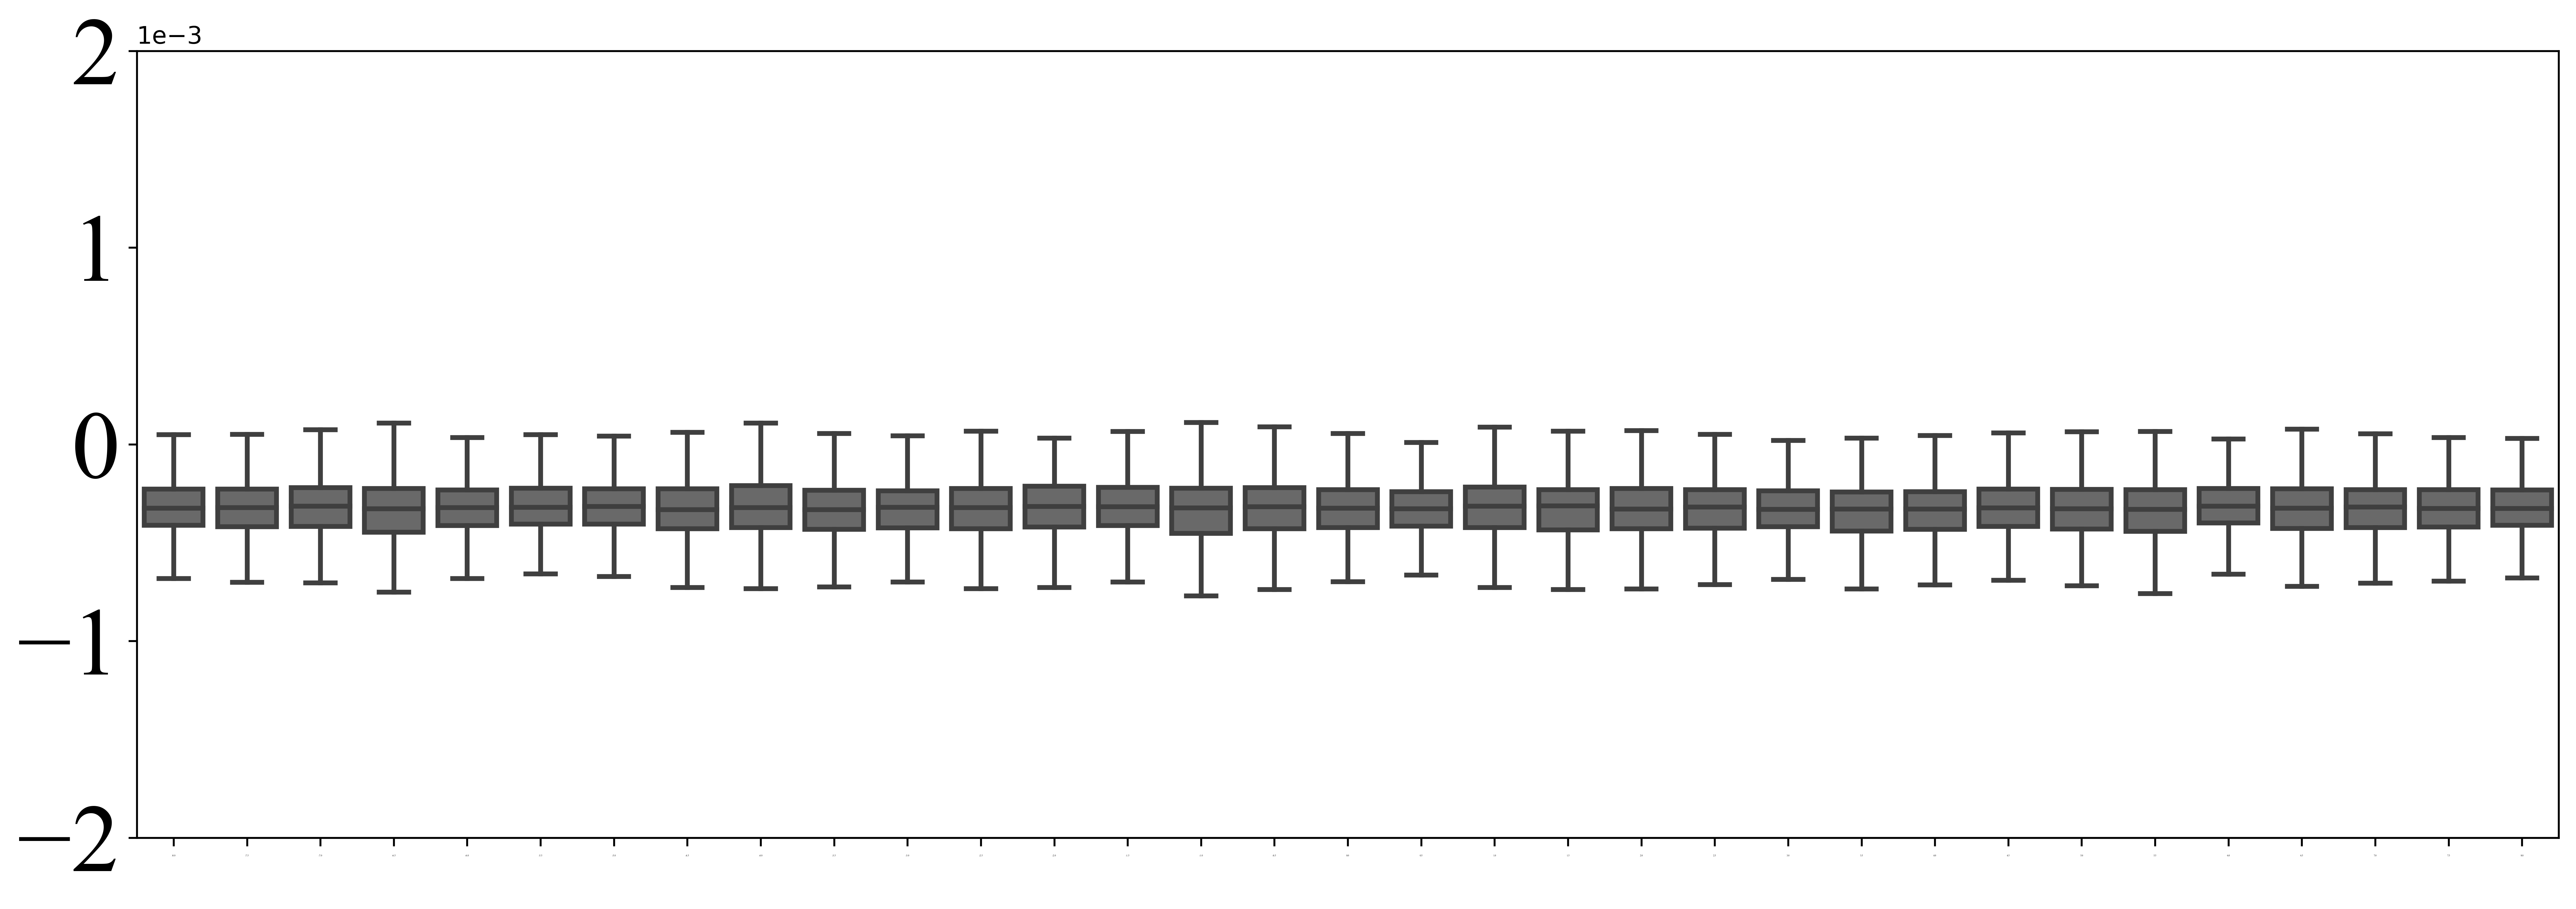

In [160]:
figsize = (18, 6)
figure, ax = plt.subplots(dpi=600,figsize=figsize)
sns.boxplot(orient='v',color="dimgray", 
              order=alpha, data=adf,ax=ax,fliersize=0,linewidth=2,width=0.8)
plt.tick_params(labelsize=40)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
# plt.xlabel("Mean of color change",font2,)
ax.set_xticklabels(labels = alpha, rotation = 0.05,fontsize = 0)
plt.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
plt.ylim(-0.002, 0.002) 
plt.savefig('Non_err.jpg')

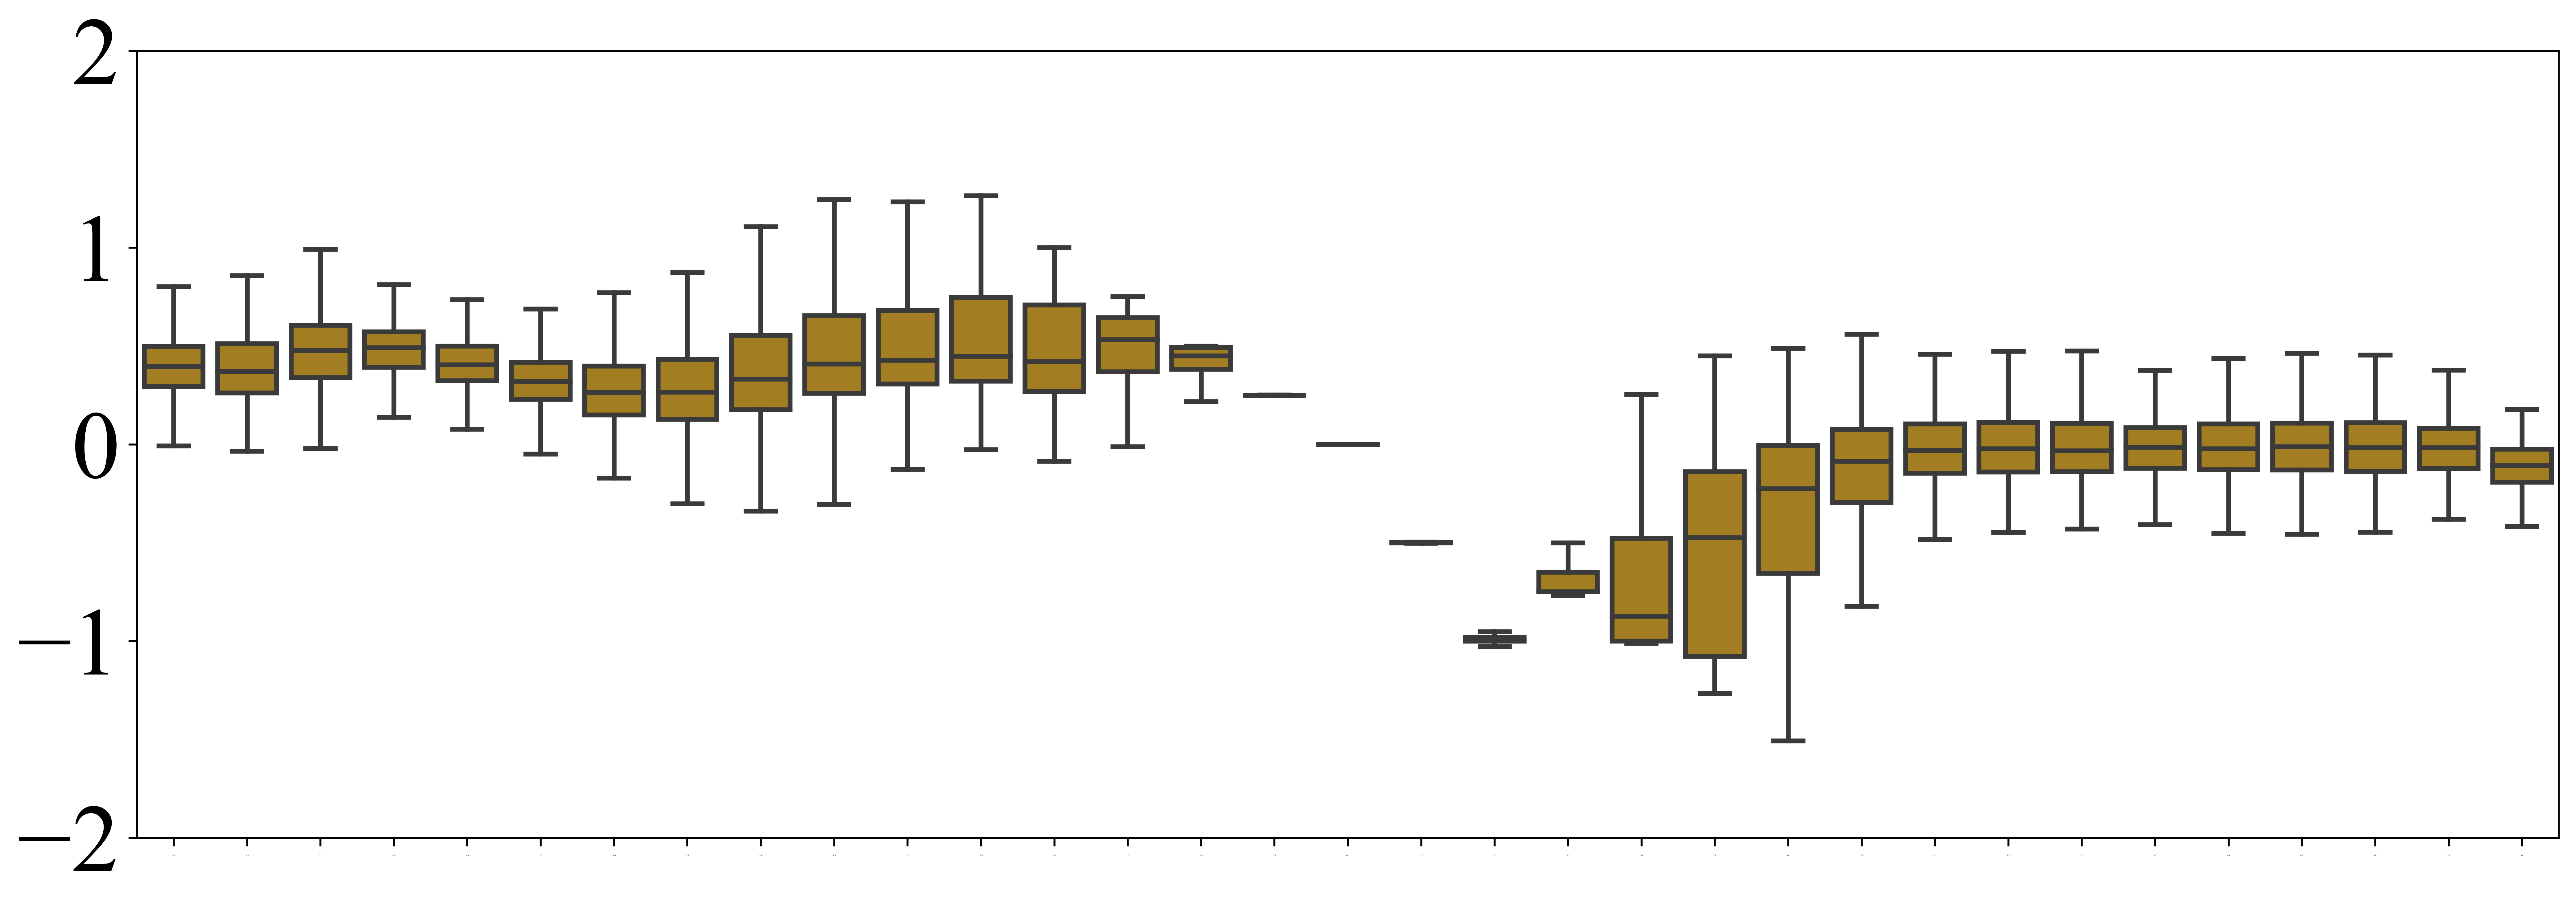

In [182]:
figsize = (18, 6)
figure, ax = plt.subplots(dpi=600,figsize=figsize)
sns.boxplot(orient='v',color="darkgoldenrod", 
              order=alpha, data=adf,ax=ax,fliersize=0,linewidth=2,width=0.8)
plt.tick_params(labelsize=40)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
# plt.xlabel("Mean of color change",font2,)
ax.set_xticklabels(labels = alpha, rotation = 0.05,fontsize = 0)
plt.ylim(-2, 2) 
plt.savefig('Audacity_err.jpg')

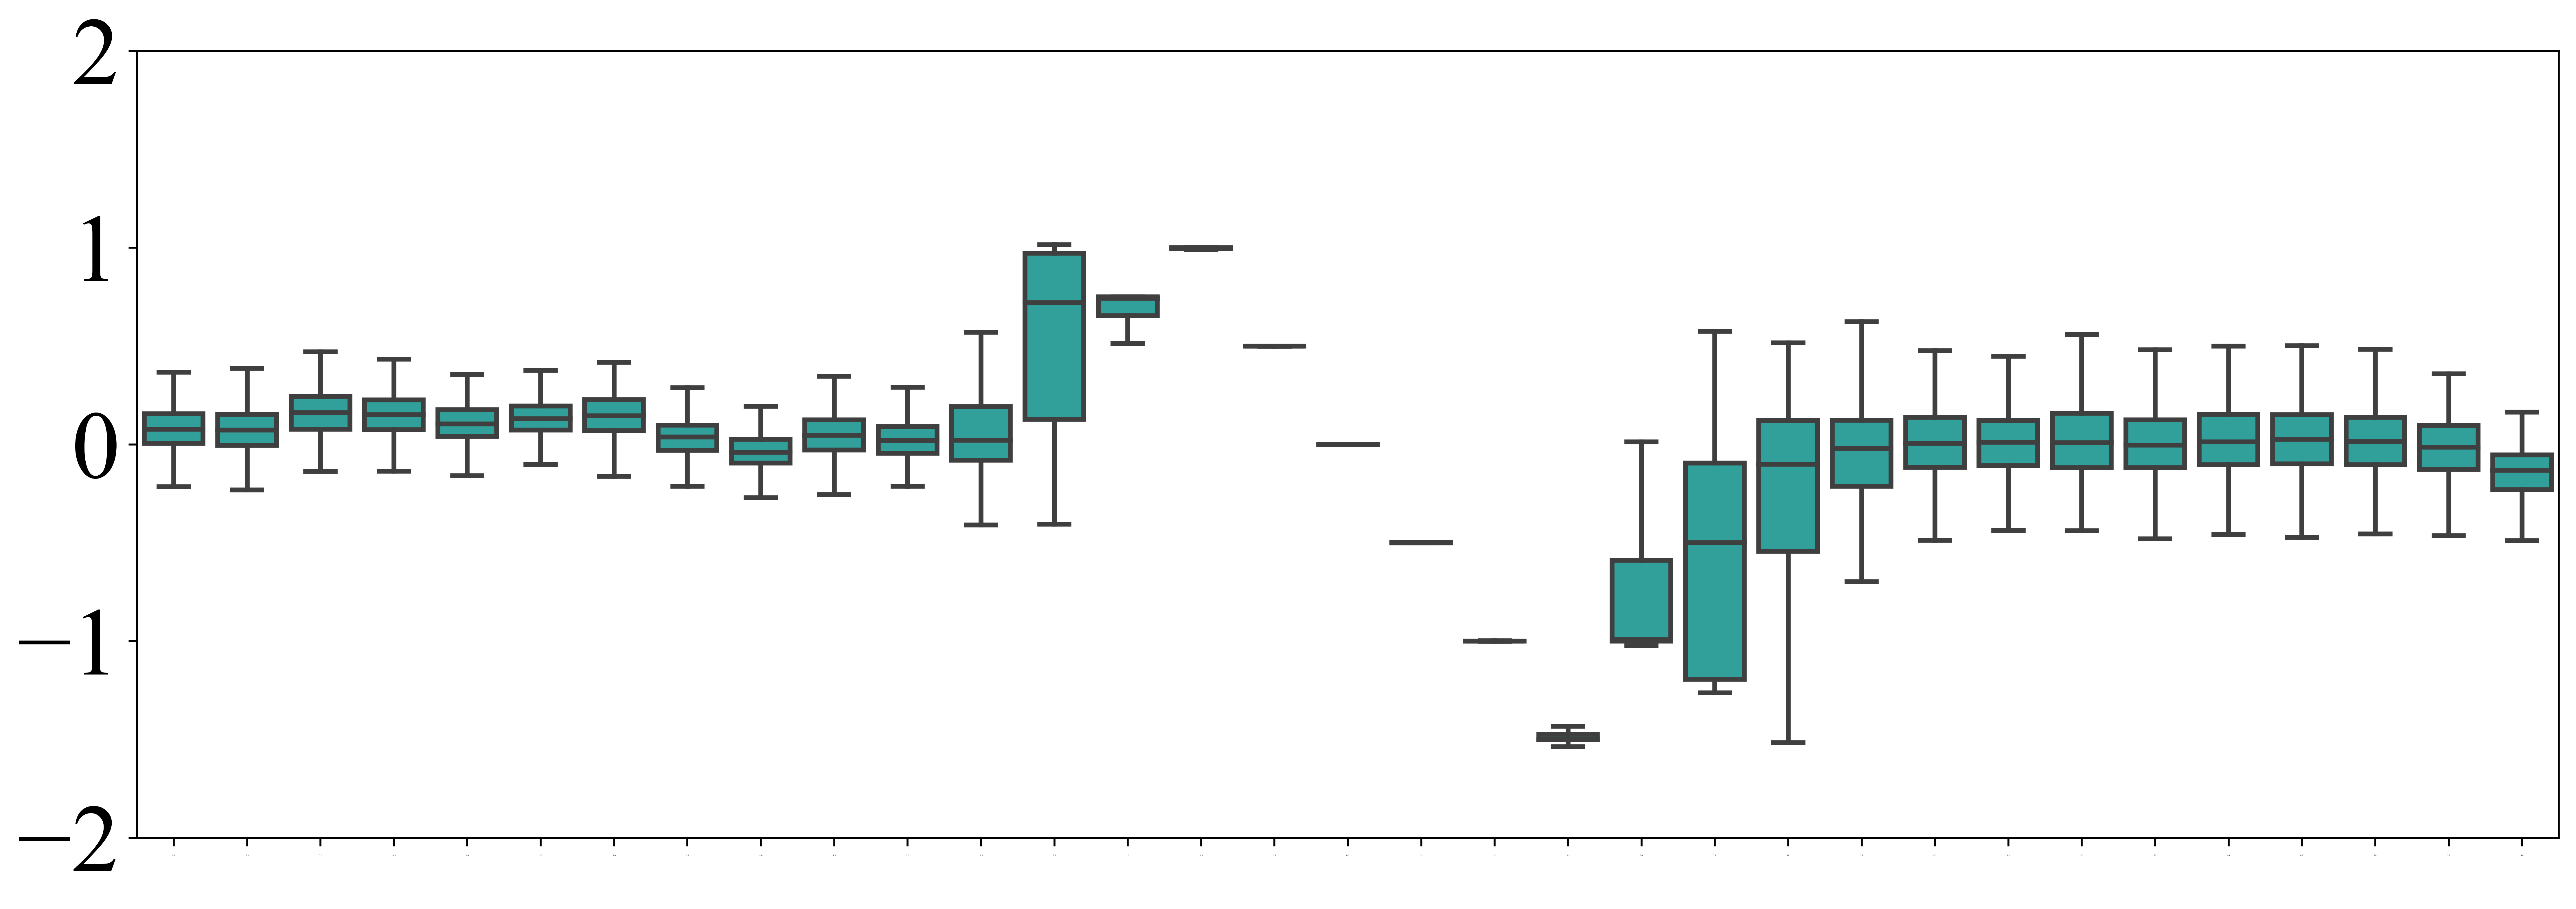

In [180]:
figsize = (18, 6)
figure, ax = plt.subplots(dpi=600,figsize=figsize)
sns.boxplot(orient='v',color="lightseagreen", 
              order=alpha, data=adf,ax=ax,fliersize=0,linewidth=2,width=0.8)
plt.tick_params(labelsize=40)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
# plt.xlabel("Mean of color change",font2,)
ax.set_xticklabels(labels = alpha, rotation = 0.05,fontsize = 0)
plt.ylim(-2, 2) 
plt.savefig('soundtouch_err.jpg')

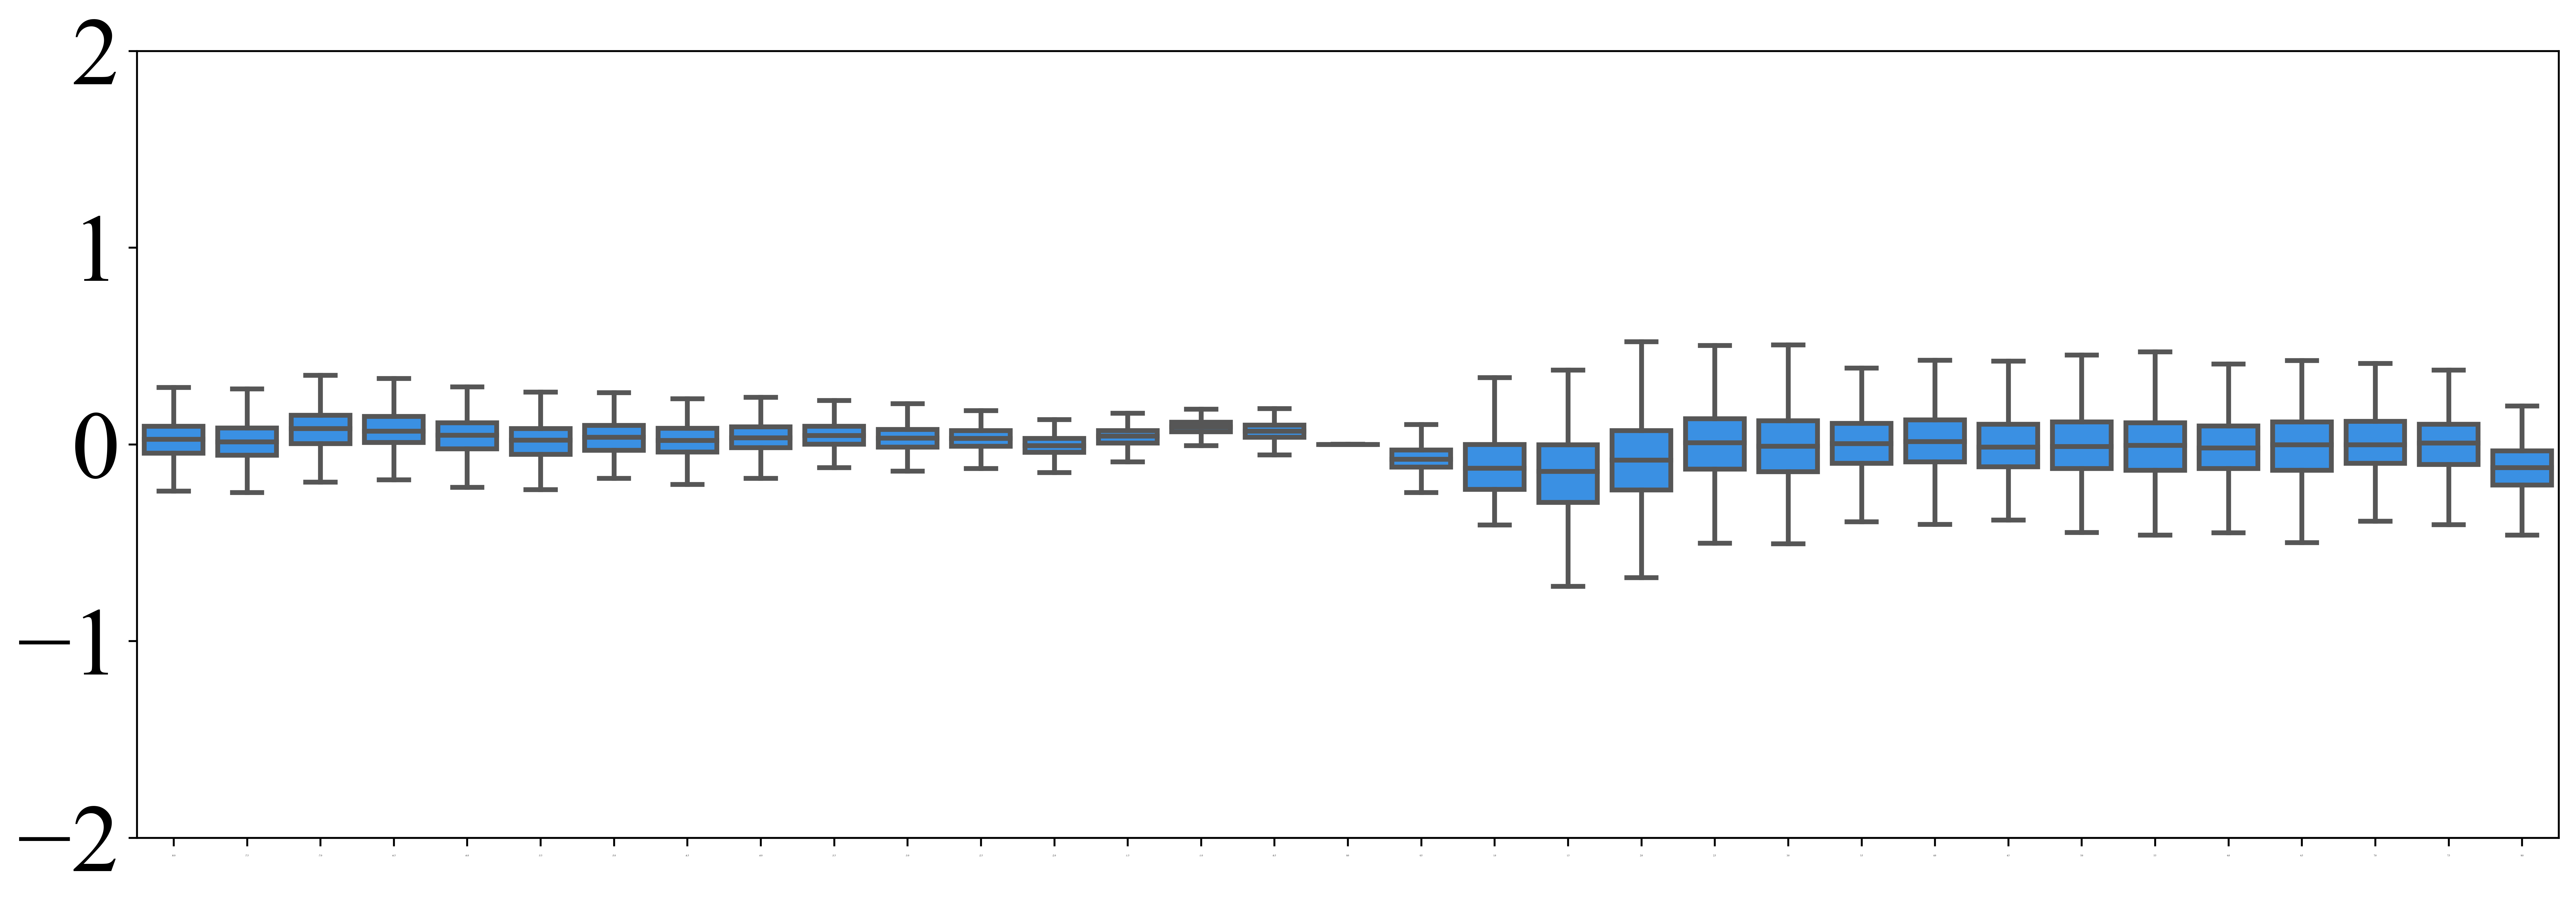

In [128]:
figsize = (18, 6)
figure, ax = plt.subplots(dpi=600,figsize=figsize)
sns.boxplot(orient='v',color="dodgerblue", 
              order=alpha, data=adf,ax=ax,fliersize=0,linewidth=2,width=0.8)
plt.tick_params(labelsize=40)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
# plt.xlabel("Mean of color change",font2,)
ax.set_xticklabels(labels = alpha, rotation = 0.05,fontsize = 0)
plt.ylim(-2, 2) 
plt.savefig('matlab_err.jpg')

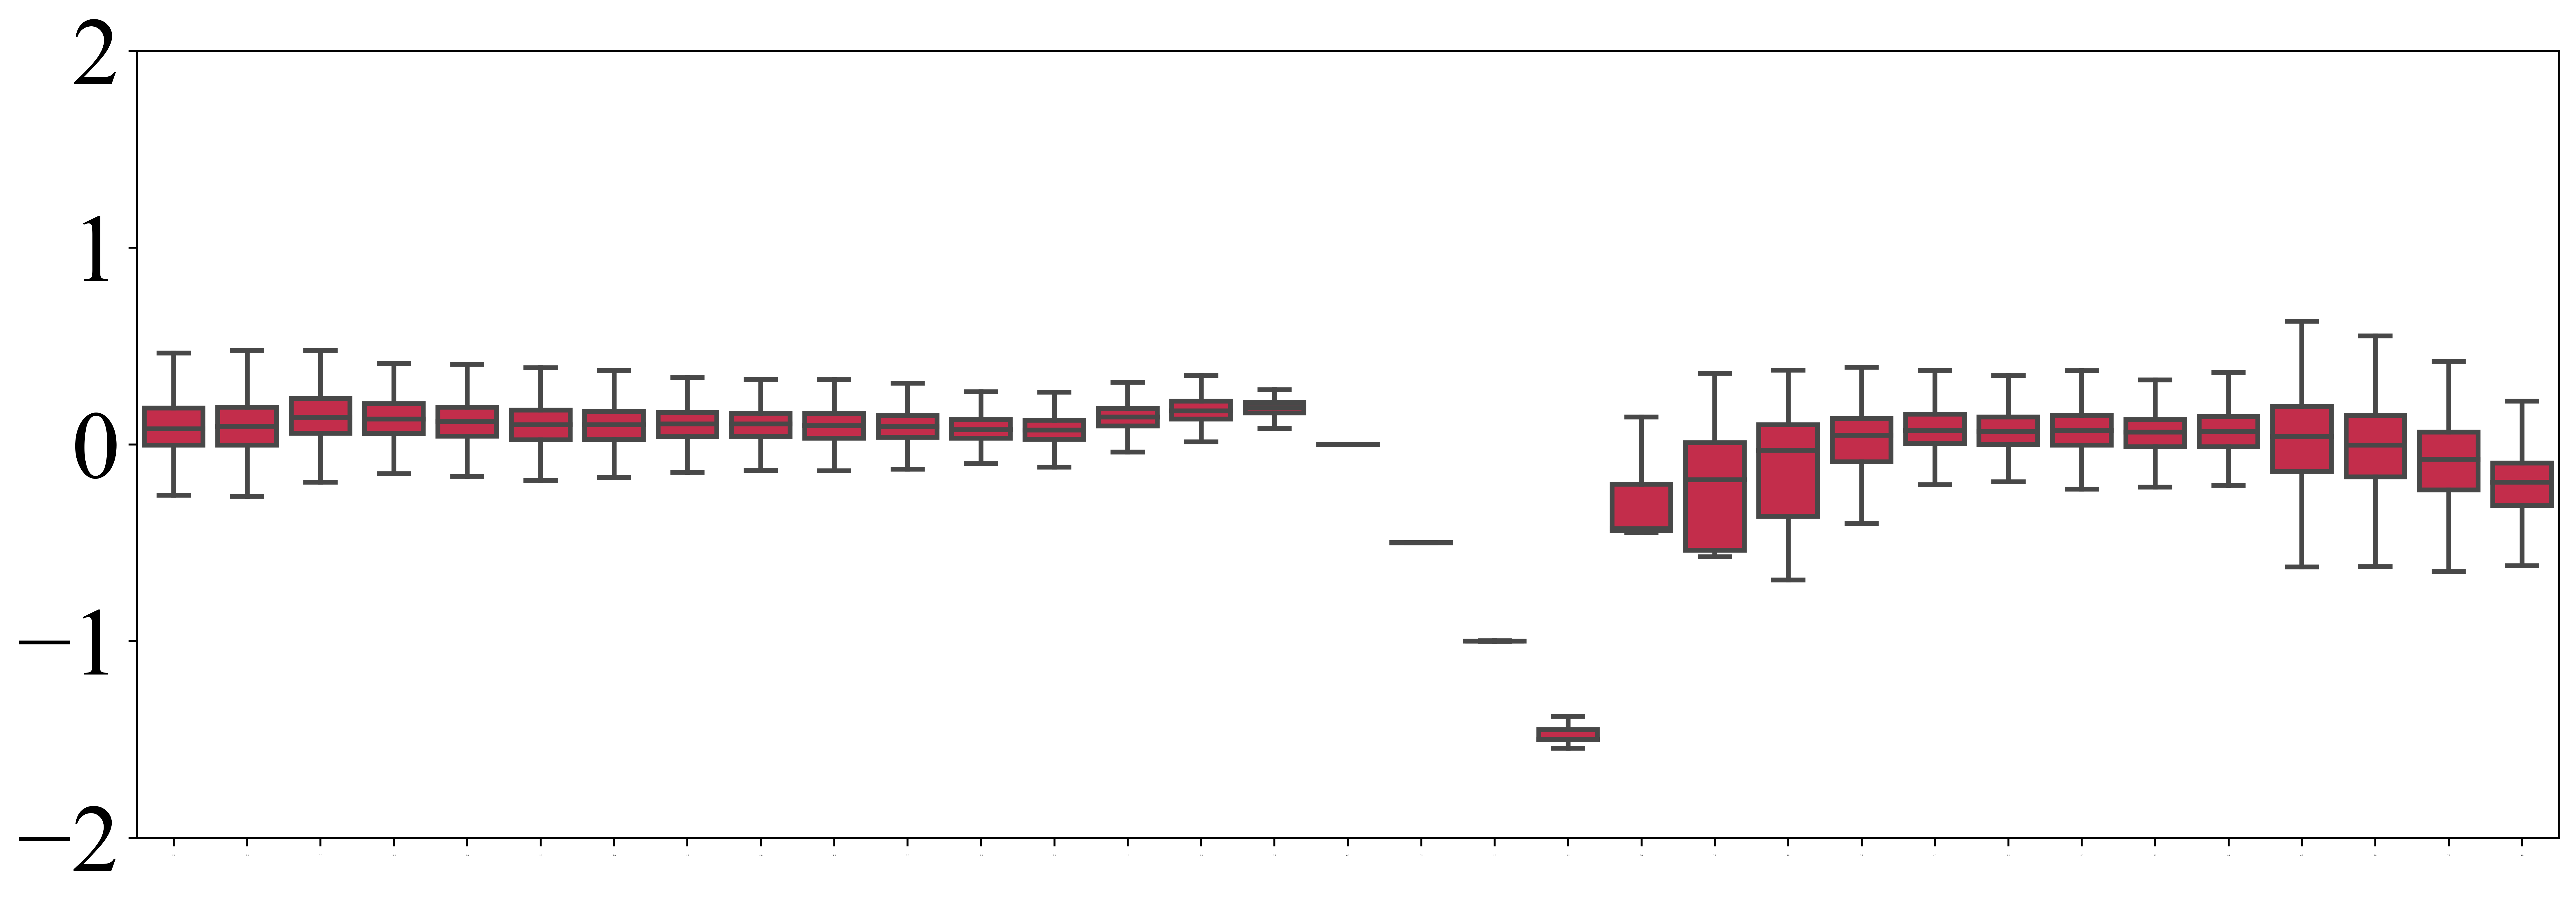

In [175]:
figsize = (18, 6)
figure, ax = plt.subplots(dpi=600,figsize=figsize)
sns.boxplot(orient='v',color="crimson", 
              order=alpha, data=adf,ax=ax,fliersize=0,linewidth=2,width=0.8)
plt.tick_params(labelsize=40)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
# plt.xlabel("Mean of color change",font2,)
ax.set_xticklabels(labels = alpha, rotation = 0.05,fontsize = 0)
plt.ylim(-2, 2) 
plt.savefig('Audition_err.jpg')

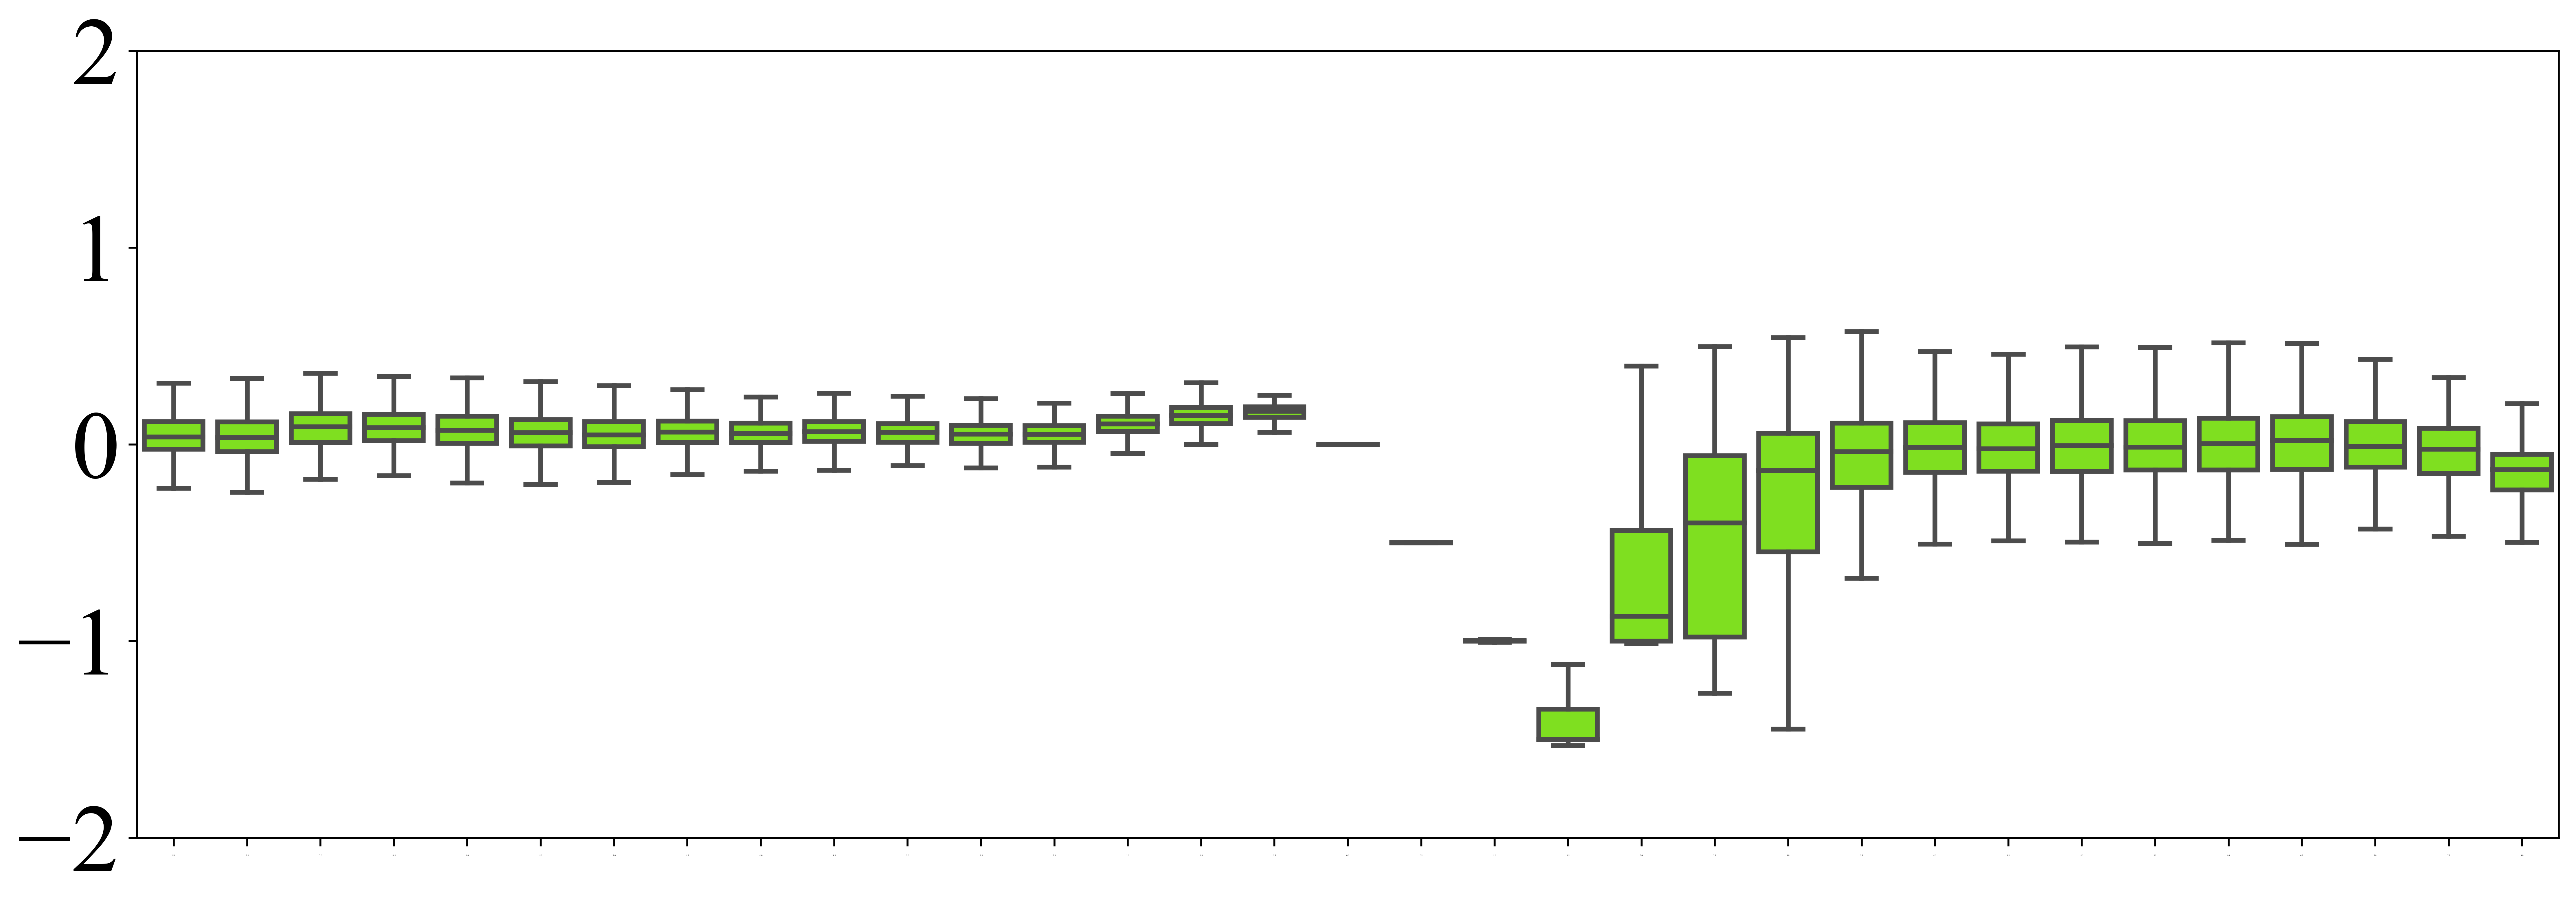

In [184]:
figsize = (18, 6)
figure, ax = plt.subplots(dpi=600,figsize=figsize)
sns.boxplot(orient='v',color="chartreuse", 
              order=alpha, data=adf,ax=ax,fliersize=0,linewidth=2,width=0.8)
plt.tick_params(labelsize=40)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
# plt.xlabel("Mean of color change",font2,)
ax.set_xticklabels(labels = alpha, rotation = 0.05,fontsize = 0)
plt.ylim(-2, 2) 
plt.savefig('iZotope_err.jpg')